#  Graduate Admissions

## Data pre-processing and exploratory analysis

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline
warnings.filterwarnings('ignore')

### Importing data

In [3]:
data_source = "./data/Admission_Predict_Ver1.1.csv"
df = pd.read_csv(data_source)

### Getting to know data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
Serial No.           500 non-null int64
GRE Score            500 non-null int64
TOEFL Score          500 non-null int64
University Rating    500 non-null int64
SOP                  500 non-null float64
LOR                  500 non-null float64
CGPA                 500 non-null float64
Research             500 non-null int64
Chance of Admit      500 non-null float64
dtypes: float64(4), int64(5)
memory usage: 35.2 KB


In [5]:
df.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [6]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


### Features
- gre_score
- toefl_score
- university_rating
- sop
- lor
- cgpa
- research

### Target
- chance_of_admit

In [7]:
# Renaming columns
df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.replace(" ", "_")
df = df.rename(index=str, columns={"lor_": "lor", "chance_of_admit_": "chance_of_admit", "serial_no.": "index"});

In [8]:
#####Dropping "serial_no." as it is not needed
#####df = df.drop(columns = ['serial_no.'])

In [9]:
# Set Index
df.set_index('index', inplace=True)

In [10]:
df.head()

,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
index,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


In [11]:
df.to_pickle(r'data/df.pkl')

## Exploratory data analysis

### Using a pairplot to visualize distribution of data and correlation among columns
- As we can see - toefl_score, gre_score and cgpa have linear relationship among themselves and with target chance_of_admit
- That means people who scored higher in gre, also scored higher in toefl and vice versa
- People with higher cgpa score higher in gre and toefl
- higher gre & toelf score means higher chance of admit

In [12]:
# sns.pairplot(df, hue = 'chance_of_admit') # uncommented to speed up compiling

### Correlation matrix
- Darker squares means higher correlation
- Best case scenario is having  many features having higher correlation with target, but lower correlation among themselves

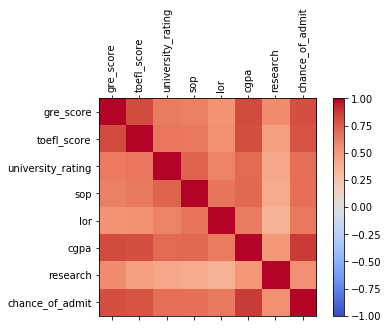

In [13]:
corr = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

## Train-Test Split

Split data to independent variables matrix (X) and dependent variable vector (y)

In [14]:
X = df.iloc[:, :-1].values
y = df.iloc[:, 7].values

Split data 

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

A couple of utility functions to plot the results from each model.

In [16]:
def plot_histogram(y_true,y_pred):
    plt.figure(figsize=(12,4))
    y_true.hist(bins=22, normed=True)
    y_pred.hist(bins=22, normed=True, alpha=0.5)
    
    
def plot_best_fit(y_true, y_pred, model_name):
    plt.figure(figsize=(12,8))
#     reorder = y_true.sort.index.tolist()
#     x_series = np.array(y_true[reorder])
#     y_series = np.array(y_pred[reorder])    
    x_series = np.array(y_true)
    y_series = np.array(y_pred)
    
    # Create scatter plot of 
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    plt.scatter(x_series, y_series, s=30, alpha=0.2, marker='o')

    # Create line of best fit and confidence intervals
    par = np.polyfit(x_series, y_series, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(x_series), max(x_series)]
    yl = [slope*x + intercept for x in xl]

    # Determine error bounds
    yerr = [abs(slope*xx + intercept - yy) for xx,yy in zip(x_series,y_series)]
    par = np.polyfit(x_series, yerr, 2, full=True)
    yerrUpper = [(xx*slope+intercept)+(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(x_series,y_series)]
    yerrLower = [(xx*slope+intercept)-(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(x_series,y_series)]

    plt.plot(xl, yl, 'r')
    plt.plot(x_series, yerrLower, '--r')
    plt.plot(x_series, yerrUpper, '--r')

    plt.xlabel("Actual Admissions")
    plt.ylabel("{} Predictoins".format(model_name))    

# Modeling


## Linear Regression

In [17]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

X_train_lin_reg = X_train
y_train_lin_reg = y_train

Principal function that outputs the final optimized theta

In [18]:
def linear_regression(X, y, alpha, num_iters):
    n = X.shape[1]
    one_column = np.ones((X.shape[0],1))
    X = np.concatenate((one_column, X), axis = 1)
    # initializing the parameter vector...
    theta = np.zeros(n+1)
    # hypothesis calculation....
    h = hypothesis(theta, X, n)
    # returning the optimized parameters by Gradient Descent...
    theta, cost = gradient_descent(theta,alpha,num_iters,h,X,y,n)
    return theta, cost

Function that calculates and outputs the hypothesis value of the target variable

In [19]:
def hypothesis(theta, X, n):
    h = np.ones((X.shape[0],1))
    theta = theta.reshape(1,n+1)
    for i in range(0,X.shape[0]):
        h[i] = float(np.matmul(theta, X[i]))
    h = h.reshape(X.shape[0])
    return h

Function that performs the gradient descent algorithm

In [20]:
def gradient_descent(theta, alpha, num_iters, h, X, y, n):
    cost = np.ones(num_iters)
    for i in range(0,num_iters):
        theta[0] = theta[0] - (alpha/X.shape[0]) * sum(h - y)
        for j in range(1,n+1):
            theta[j] = theta[j] - (alpha/X.shape[0]) * sum((h-y) * X.transpose()[j])
        h = hypothesis(theta, X, n)
        cost[i] = (1/X.shape[0]) * 0.5 * sum(np.square(h - y))
    theta = theta.reshape(1,n+1)
    return theta, cost

Feature scaling

In [21]:
mean_train = np.ones(X_train_lin_reg.shape[1])
std_train = np.ones(X_train_lin_reg.shape[1])
for i in range(0, X_train_lin_reg.shape[1]):
    mean_train[i] = np.mean(X_train_lin_reg.transpose()[i])
    std_train[i] = np.std(X_train_lin_reg.transpose()[i])
    for j in range(0, X_train_lin_reg.shape[0]):
        X_train_lin_reg[j][i] = (X_train_lin_reg[j][i] - mean_train[i])/std_train[i]   
        
mean_test = np.ones(X_test.shape[1])
std_test = np.ones(X_test.shape[1])
for i in range(0, X_test.shape[1]):
    mean_test[i] = np.mean(X_test.transpose()[i])
    std_test[i] = np.std(X_test.transpose()[i])
    for j in range(0, X_test.shape[0]):
        X_test[j][i] = (X_test[j][i] - mean_test[i])/std_test[i]      

Calling the principal function with learning_rate = 0.01

In [22]:
num_iters = 1000
theta, cost = linear_regression(X_train_lin_reg, y_train_lin_reg, 0.01, num_iters)

The reduction in the cost 

Text(0,0.5,'Cost')

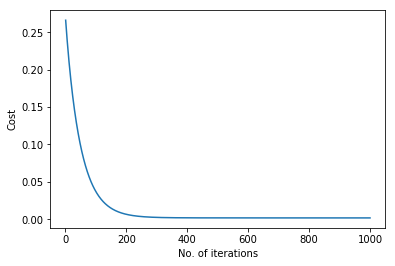

In [23]:
import matplotlib.pyplot as plt
cost = list(cost)
n_iterations = [x for x in range(1,num_iters+1)]
plt.plot(n_iterations, cost)
plt.xlabel('No. of iterations')
plt.ylabel('Cost')

Predictions:

In [24]:
X_test_lin_reg = np.concatenate((np.ones((X_test.shape[0],1)), X_test) ,axis = 1)
predictions_lin_reg = hypothesis(theta, X_test_lin_reg, X_test_lin_reg.shape[1] - 1)

In [25]:
print(np.sqrt(metrics.mean_squared_error(y_test, predictions_lin_reg)))

0.0618767204629624


Plot predictions and test data 

Text(0,0.5,'Chance of Admission')

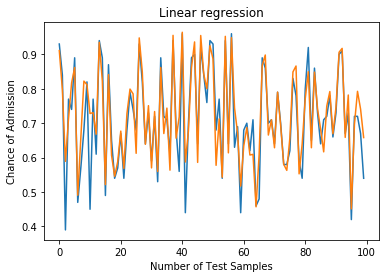

In [26]:
plt.plot(y_test.ravel(), '-', predictions_lin_reg, '-')
plt.title('Linear regression')
plt.xlabel('Number of Test Samples') 
plt.ylabel('Chance of Admission')

Test accurency:

In [27]:
output_error = y_test - predictions_lin_reg

error_lin_reg = np.mean(np.abs(output_error))
accuracy_lin_reg = (1 - error_lin_reg) * 100

print("Test Accuracy " + str(round(accuracy_lin_reg,2)) + "%")

Test Accuracy 95.75%


Save results to csv file

In [28]:
output_col_order = ['ChanceOfAdmit', 'Predicted', 'Delta']
result_lin_reg = pd.DataFrame({'ChanceOfAdmit':y_test,
                               'Predicted':predictions_lin_reg,
                               'Delta': abs(y_test - predictions_lin_reg)})
                        
result_lin_reg[output_col_order].to_csv('results/LinearRegression.csv', index=False)

### Feature engineering # 1

We chose 'gre score', 'toefl score', and 'cgpa' columns that seemed the most important in getting admitted

In [29]:
X_lin_reg_fe1 = df[['gre_score', 'toefl_score', 'cgpa']]
X_lin_reg_fe1 = X_lin_reg_fe1.iloc[:,:].values
y_lin_reg_fe1 = y

Train-Test Split

In [30]:
from sklearn.model_selection import train_test_split
X_train_lin_reg_fe1, X_test_lin_reg_fe1, y_train_lin_reg_fe1, y_test_lin_reg_fe1 = train_test_split(X_lin_reg_fe1, y_lin_reg_fe1, test_size=0.2, random_state = 42)

Feature scaling

In [31]:
mean_train_fe1 = np.ones(X_train_lin_reg_fe1.shape[1])
std_train_fe1 = np.ones(X_train_lin_reg_fe1.shape[1])
for i in range(0, X_train_lin_reg_fe1.shape[1]):
    mean_train_fe1[i] = np.mean(X_train_lin_reg_fe1.transpose()[i])
    std_train_fe1[i] = np.std(X_train_lin_reg_fe1.transpose()[i])
    for j in range(0, X_train_lin_reg_fe1.shape[0]):
        X_train_lin_reg_fe1[j][i] = (X_train_lin_reg_fe1[j][i] - mean_train_fe1[i])/std_train_fe1[i]
        
mean_test_fe1 = np.ones(X_test_lin_reg_fe1.shape[1])
std_test = np.ones(X_test_lin_reg_fe1.shape[1])
for i in range(0, X_test_lin_reg_fe1.shape[1]):
    mean_test[i] = np.mean(X_test_lin_reg_fe1.transpose()[i])
    std_test[i] = np.std(X_test_lin_reg_fe1.transpose()[i])
    for j in range(0, X_test_lin_reg_fe1.shape[0]):
        X_test_lin_reg_fe1[j][i] = (X_test_lin_reg_fe1[j][i] - mean_test[i])/std_test[i]

Calling the principal function with learning_rate = 0.01

In [32]:
num_iters = 1000
theta_reg_fe1, cost_reg_fe1 = linear_regression(X_train_lin_reg_fe1, y_train_lin_reg_fe1, 0.01, num_iters)

Predictions:

In [33]:
X_test_lin_reg_fe1 = np.concatenate((np.ones((X_test_lin_reg_fe1.shape[0],1)), X_test_lin_reg_fe1) ,axis = 1)
predictions_lin_reg_fe1 = hypothesis(theta_reg_fe1, X_test_lin_reg_fe1, X_test_lin_reg_fe1.shape[1] - 1)

In [34]:
print(np.sqrt(metrics.mean_squared_error(y_test, predictions_lin_reg_fe1)))

0.06610037031580543


Text(0,0.5,'Chance of Admission')

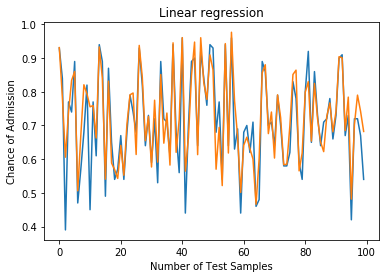

In [35]:
plt.plot(y_test.ravel(), '-', predictions_lin_reg_fe1, '-')
plt.title('Linear regression')
plt.xlabel('Number of Test Samples') 
plt.ylabel('Chance of Admission')

In [36]:
output_error_fe1 = y_test - predictions_lin_reg_fe1

error_lin_reg_fe1 = np.mean(np.abs(output_error_fe1))
accuracy_lin_reg_fe1 = (1 - error_lin_reg_fe1) * 100

print("Test Accuracy " + str(round(accuracy_lin_reg_fe1,2)) + "%")

Test Accuracy 95.44%


### Feature engineering # 2

We chose only 'gre score', and 'cgpa' columns that seemed the most important in getting admitted

In [37]:
X_lin_reg_fe2 = df[['gre_score', 'cgpa']]
X_lin_reg_fe2 = X_lin_reg_fe2.iloc[:,:].values
y_lin_reg_fe2 = y

Train-Test Split

In [38]:
from sklearn.model_selection import train_test_split
X_train_lin_reg_fe2, X_test_lin_reg_fe2, y_train_lin_reg_fe2, y_test_lin_reg_fe2 = train_test_split(X_lin_reg_fe2, y_lin_reg_fe2, test_size=0.2, random_state = 42)

Feature scaling

In [39]:
mean_train_fe2 = np.ones(X_train_lin_reg_fe2.shape[1])
std_train_fe2 = np.ones(X_train_lin_reg_fe2.shape[1])
for i in range(0, X_train_lin_reg_fe2.shape[1]):
    mean_train_fe2[i] = np.mean(X_train_lin_reg_fe2.transpose()[i])
    std_train_fe2[i] = np.std(X_train_lin_reg_fe2.transpose()[i])
    for j in range(0, X_train_lin_reg_fe2.shape[0]):
        X_train_lin_reg_fe2[j][i] = (X_train_lin_reg_fe2[j][i] - mean_train_fe2[i])/std_train_fe2[i]
        
mean_test_fe2 = np.ones(X_test_lin_reg_fe2.shape[1])
std_test = np.ones(X_test_lin_reg_fe2.shape[1])
for i in range(0, X_test_lin_reg_fe2.shape[1]):
    mean_test[i] = np.mean(X_test_lin_reg_fe2.transpose()[i])
    std_test[i] = np.std(X_test_lin_reg_fe2.transpose()[i])
    for j in range(0, X_test_lin_reg_fe2.shape[0]):
        X_test_lin_reg_fe2[j][i] = (X_test_lin_reg_fe2[j][i] - mean_test[i])/std_test[i]

Calling the principal function with learning_rate = 0.01

In [40]:
num_iters = 1000
theta_reg_fe2, cost_reg_fe2 = linear_regression(X_train_lin_reg_fe2, y_train_lin_reg_fe2, 0.01, num_iters)

Text(0,0.5,'Cost')

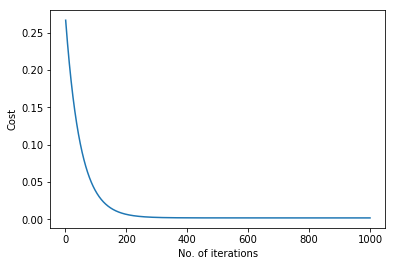

In [41]:
import matplotlib.pyplot as plt
cost_reg_fe2 = list(cost_reg_fe2)
n_iterations = [x for x in range(1,num_iters+1)]
plt.plot(n_iterations, cost_reg_fe2)
plt.xlabel('No. of iterations')
plt.ylabel('Cost')

Predictions:

In [42]:
X_test_lin_reg_fe2 = np.concatenate((np.ones((X_test_lin_reg_fe2.shape[0],1)), X_test_lin_reg_fe2) ,axis = 1)
predictions_lin_reg_fe2 = hypothesis(theta_reg_fe2, X_test_lin_reg_fe2, X_test_lin_reg_fe2.shape[1] - 1)

In [43]:
print(np.sqrt(metrics.mean_squared_error(y_test, predictions_lin_reg_fe2)))

0.0662220061059784


Text(0,0.5,'Chance of Admission')

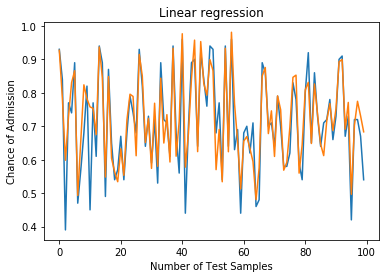

In [44]:
plt.plot(y_test.ravel(), '-', predictions_lin_reg_fe2, '-')
plt.title('Linear regression')
plt.xlabel('Number of Test Samples') 
plt.ylabel('Chance of Admission')

In [45]:
output_error_fe2 = y_test - predictions_lin_reg_fe2

error_lin_reg_fe2 = np.mean(np.abs(output_error_fe2))
accuracy_lin_reg_fe2 = (1 - error_lin_reg_fe2) * 100

print("Test Accuracy " + str(round(accuracy_lin_reg_fe2,2)) + "%")

Test Accuracy 95.36%


# Modeling


## XGBoost

[XGBoost](http://xgboost.readthedocs.io/en/latest/) is perhaps the most popular package for modelling in Kaggle competitions as it is extremely fast and provides state-of-the-art performance with gradient boosting.

In [46]:
#Install code ran in Anaconda Prompt:
#pip install xgboost

In [47]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [48]:
params = {'max_depth':4,
          'subsample':1.0,
          'colsample_bytree':1.0,
          'min_child_weight':20,
          'eta':0.02,
          'silent':1,
          'objective':'count:poisson',
          'eval_metric':'mae',
          'seed': 9753}
num_rounds=500

In [49]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain,'train'), (dtest, 'eval')]
bst = xgb.train(params.items(), dtrain, num_rounds, watchlist, early_stopping_rounds=50)

NameError: name 'xgb' is not defined

In [50]:
y_xgb = bst.predict(xgb.DMatrix(X_test), ntree_limit=bst.best_ntree_limit)
y_xgb = pd.Series(y_xgb, name='Pred_XGBoost')#, index=X_test.index

NameError: name 'bst' is not defined

In [51]:
y_xgb.describe()

NameError: name 'y_xgb' is not defined

In [52]:
output_col_order = ['ChanceOfAdmit', 'Predicted', 'Delta']
result_xgboost = pd.DataFrame({'ChanceOfAdmit':y_test,
                               'Predicted':y_xgb,
                               'Delta': abs(y_test - y_xgb)})

result_xgboost[output_col_order].to_csv('results/XGBoost.csv', index=False)

NameError: name 'y_xgb' is not defined

# Modeling


## Negative Binomial

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  400
Model:                            GLM   Df Residuals:                      393
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -363.69
Date:                Mon, 13 May 2019   Deviance:                       38.594
Time:                        16:26:30   Pearson chi2:                     34.1
No. Iterations:                     4   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0267      0.108      0.247      0.805      -0.185       0.238
x2             0.0165      0.096      0.172      0.8

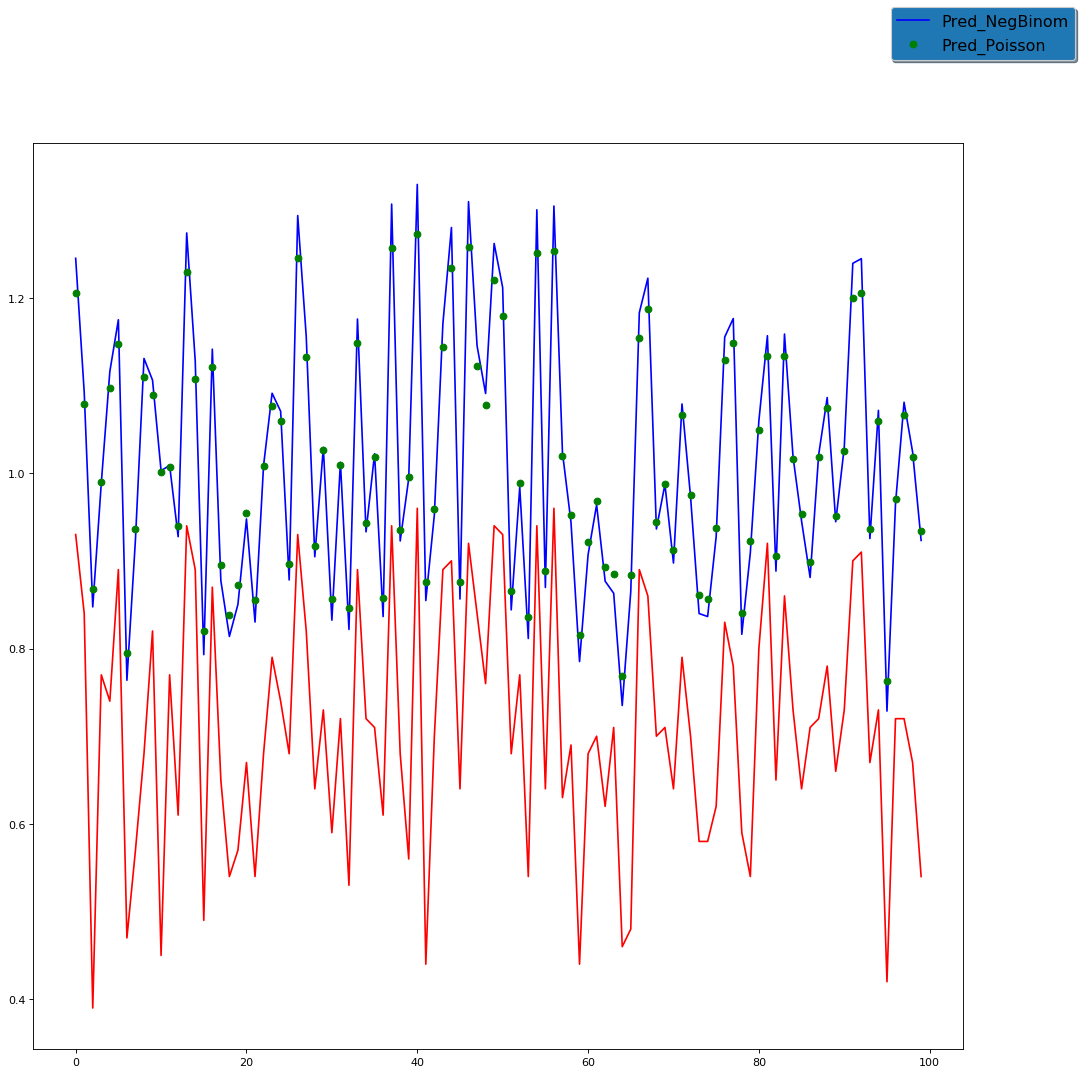

,ChanceOfAdmit,Predicted,Delta
0,0.93,1.245021,0.315021
1,0.84,1.092291,0.252291
2,0.39,0.847478,0.457478
3,0.77,0.988619,0.218619
4,0.74,1.115971,0.375971
5,0.89,1.174961,0.284961
6,0.47,0.763804,0.293804
7,0.57,0.924465,0.354465
8,0.68,1.130840,0.450840
9,0.82,1.106074,0.286074


In [57]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error


modelP = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
modelNB = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial()).fit()

print(modelP.summary())
print()
print()
print(modelNB.summary())

y_p = modelP.predict(X_test)
y_nb = modelNB.predict(X_test)

y_nb = pd.Series(y_nb, name='Pred_NegBinom')
y_p = pd.Series(y_p, name='Pred_Poisson')


print("Poisson -->")
print(accuracy_score(y_test.round(), np.rint(y_nb)), mean_absolute_error(y_test, np.rint(y_nb)))
print()
print("Negative Binomial -->")
print(accuracy_score(y_test.round(), np.rint(y_p)), mean_absolute_error(y_test, np.rint(y_nb)))

fig=plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(y_test, 'r')
plt.plot(y_nb, 'b')
plt.plot(y_p, 'go')
legend = fig.legend(loc='upper right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C0')
plt.show()

output_col_order = ["ChanceOfAdmit", "Predicted", "Delta"]
result_neg_binom = pd.DataFrame({"ChanceOfAdmit":y_test,
                              "Predicted":y_nb,
                              "Delta":abs(y_test - y_nb)})

output_col_order = ['ChanceOfAdmit', 'Predicted', 'Delta']
result_lin_reg = pd.DataFrame({'ChanceOfAdmit':y_test,
                               'Predicted':predictions_lin_reg,
                               'Delta': abs(y_test - predictions_lin_reg)})
                        
result_lin_reg[output_col_order].to_csv('results/LinearRegression.csv', index=False)

result_neg_binom
result_neg_binom.to_csv("results/NegativeBinomial.csv", index=False)